In [4]:
import pandas as pd
from pathlib import Path

DATA = Path("data/processed")

try:
    opt = pd.read_parquet(DATA / "pricing_results_SPY.parquet")
    print("✅ Loaded Parquet.")
except Exception as e:
    print("⚠️ Parquet load failed:", e, "\n→ Trying Pickle instead...")
    opt = pd.read_pickle(DATA / "pricing_results_SPY.pkl")
    print("✅ Loaded Pickle fallback.")

print(len(opt), "rows loaded")
opt.head()


✅ Loaded Parquet.
1128 rows loaded


,trade_date,expiry,strike,S,T,r_ann,r_cont,price,option_type,price_source,...,err_sig_rv63,price_sig_pk21,err_sig_pk21,price_sig_ewma,err_sig_ewma,price_sig_garch,err_sig_garch,moneyness,tenor_bucket,mny_bucket
0,2025-10-13,2025-10-16,550.0,663.039978,0.008219,0.03849,0.037768,112.375,call,mid,...,0.776605,NaN,NaN,113.151605,0.776605,113.151605,0.776605,0.829513,"(-0.001, 7.0]","(0.8, 0.9]"
1,2025-10-13,2025-10-16,570.0,663.039978,0.008219,0.03849,0.037768,92.455,call,mid,...,0.702813,NaN,NaN,93.157813,0.702813,93.157813,0.702813,0.859677,"(-0.001, 7.0]","(0.8, 0.9]"
2,2025-10-13,2025-10-16,575.0,663.039978,0.008219,0.03849,0.037768,87.345,call,mid,...,0.814365,NaN,NaN,88.159365,0.814365,88.159365,0.814365,0.867218,"(-0.001, 7.0]","(0.8, 0.9]"
3,2025-10-13,2025-10-16,601.0,663.039978,0.008219,0.03849,0.037768,61.575,call,mid,...,0.592434,NaN,NaN,62.167434,0.592434,62.167434,0.592434,0.906431,"(-0.001, 7.0]","(0.9, 1.0]"
4,2025-10-13,2025-10-16,602.0,663.039978,0.008219,0.03849,0.037768,60.545,call,mid,...,0.622745,NaN,NaN,61.167745,0.622745,61.167745,0.622745,0.907939,"(-0.001, 7.0]","(0.9, 1.0]"


In [7]:
import numpy as np
import pandas as pd

# discover models from error columns created in nb3
models = sorted({c.replace("err_","") for c in opt.columns if c.startswith("err_")})
assert models, "No model error columns found (err_*)."

def summarize(df):
    rows = []
    for m in models:
        e = df[f"err_{m}"].dropna()
        if len(e)==0: 
            continue
        rows.append({
            "model": m,
            "count": len(e),
            "MAE": e.abs().mean(),
            "RMSE": np.sqrt((e**2).mean()),
            "MedianAE": e.abs().median()
        })
    return (pd.DataFrame(rows)
            .sort_values(["RMSE","MAE","MedianAE"])
            .reset_index(drop=True))

overall = summarize(opt)
display(overall)

best_model = overall.iloc[0]["model"]
print("Best model by RMSE →", best_model)


,model,count,MAE,RMSE,MedianAE
0,sig_rv21,1128,0.953809,1.276359,0.739604
1,sig_rv63,1128,1.093330,1.456339,0.841350
2,sig_garch,1128,1.205442,1.612126,0.909118
3,sig_ewma,1128,1.371507,1.862854,0.974842


Best model by RMSE → sig_rv21


In [6]:
def group_leaderboard(df, by):
    if by not in df.columns:
        print(f"Column '{by}' not found — skipping.")
        return None
    out = (df.groupby(by, observed=True, sort=False)
             .apply(summarize)
             .reset_index(level=0)
          )
    display(out)
    return out

print("By tenor bucket")
tenor_lb = group_leaderboard(opt, "tenor_bucket")

print("\nBy moneyness bucket")
mny_lb = group_leaderboard(opt, "mny_bucket")


By tenor bucket


C:\Users\biboz\AppData\Local\Temp\ipykernel_7616\2888364751.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize)


,tenor_bucket,model,count,MAE,RMSE,MedianAE
0,"(-0.001, 7.0]",sig_rv21,620,0.668189,0.947120,0.491114
1,"(-0.001, 7.0]",sig_rv63,620,0.738910,1.054500,0.511702
2,"(-0.001, 7.0]",sig_garch,620,0.795180,1.147366,0.520669
3,"(-0.001, 7.0]",sig_ewma,620,0.877582,1.296888,0.528725
0,"(7.0, 30.0]",sig_rv21,508,1.302400,1.588252,1.220722
1,"(7.0, 30.0]",sig_rv63,508,1.525890,1.830935,1.452157
2,"(7.0, 30.0]",sig_garch,508,1.706157,2.040640,1.640501
3,"(7.0, 30.0]",sig_ewma,508,1.974327,2.377563,1.866754



By moneyness bucket


C:\Users\biboz\AppData\Local\Temp\ipykernel_7616\2888364751.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize)


,mny_bucket,model,count,MAE,RMSE,MedianAE
0,"(0.8, 0.9]",sig_rv21,82,0.229754,0.287027,0.189522
1,"(0.8, 0.9]",sig_rv63,82,0.229754,0.287027,0.189522
2,"(0.8, 0.9]",sig_garch,82,0.229754,0.287027,0.189522
3,"(0.8, 0.9]",sig_ewma,82,0.229754,0.287027,0.189522
0,"(0.9, 1.0]",sig_rv21,572,1.280247,1.530438,1.348123
1,"(0.9, 1.0]",sig_rv63,572,1.418219,1.723924,1.401434
2,"(0.9, 1.0]",sig_garch,572,1.528706,1.885381,1.436080
3,"(0.9, 1.0]",sig_ewma,572,1.692159,2.137152,1.459286
0,"(1.0, 1.1]",sig_rv21,378,0.761988,1.042005,0.732982
1,"(1.0, 1.1]",sig_rv63,378,0.969554,1.265158,0.903895


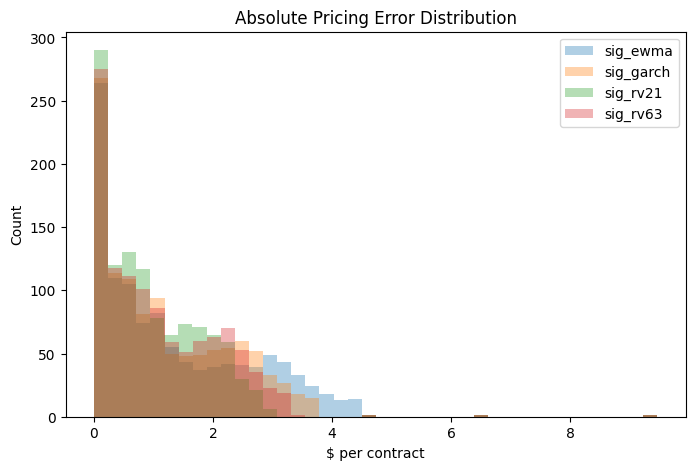

<Figure size 900x500 with 0 Axes>

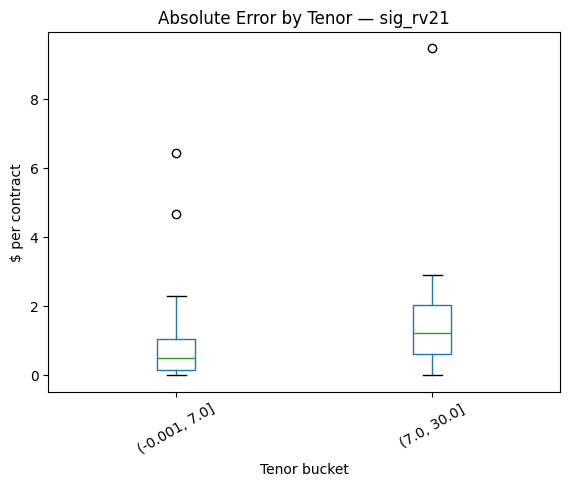

<Figure size 900x500 with 0 Axes>

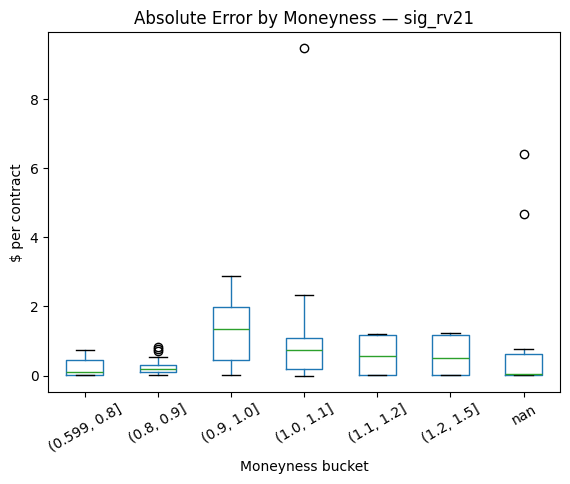

In [8]:
import matplotlib.pyplot as plt

# 1) Error distribution (absolute) for all models
plt.figure(figsize=(8,5))
for m in models:
    e = opt[f"err_{m}"].dropna().abs()
    if len(e): plt.hist(e, bins=40, alpha=0.35, label=m)
plt.title("Absolute Pricing Error Distribution")
plt.xlabel("$ per contract"); plt.ylabel("Count")
plt.legend(); plt.show()

# 2) Boxplot by tenor for best model
if "tenor_bucket" in opt.columns:
    plt.figure(figsize=(9,5))
    (opt.assign(abs_err=lambda d: d[f"err_{best_model}"].abs())
        .dropna(subset=["abs_err","tenor_bucket"])
        .boxplot(column="abs_err", by="tenor_bucket", grid=False, rot=30))
    plt.title(f"Absolute Error by Tenor — {best_model}"); plt.suptitle("")
    plt.xlabel("Tenor bucket"); plt.ylabel("$ per contract")
    plt.show()

# 3) Boxplot by moneyness for best model
if "mny_bucket" in opt.columns:
    plt.figure(figsize=(9,5))
    (opt.assign(abs_err=lambda d: d[f"err_{best_model}"].abs())
        .dropna(subset=["abs_err","mny_bucket"])
        .boxplot(column="abs_err", by="mny_bucket", grid=False, rot=30))
    plt.title(f"Absolute Error by Moneyness — {best_model}"); plt.suptitle("")
    plt.xlabel("Moneyness bucket"); plt.ylabel("$ per contract")
    plt.show()


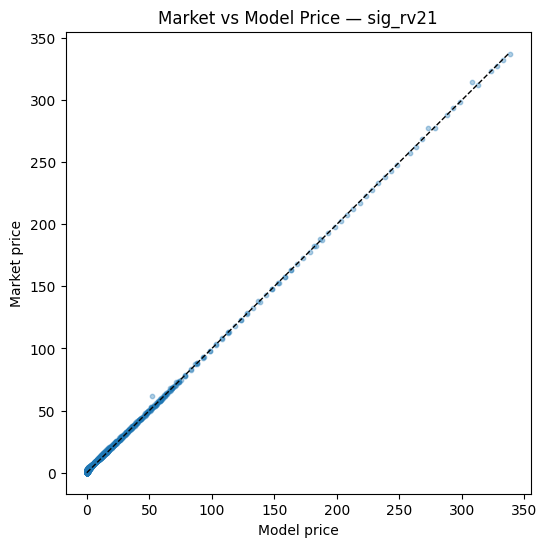

Usable regressors: ['S', 'strike', 'T', 'moneyness', 'r_cont', 'sig_rv21', 'sig_rv63', 'sig_ewma', 'sig_garch']
                            OLS Regression Results                            
Dep. Variable:                abs_err   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     595.8
Date:                Wed, 15 Oct 2025   Prob (F-statistic):          8.98e-232
Time:                        13:33:54   Log-Likelihood:                -1309.2
No. Observations:                1128   AIC:                             2624.
Df Residuals:                    1125   BIC:                             2640.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

C:\Users\biboz\Documents\Projects\ftse-options-efficiency-vol-forecasting\venv311\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 3
  warnings.warn('covariance of constraints does not have full '


In [11]:
# 1) Price scatter vs 1:1 line
plt.figure(figsize=(6,6))
y = opt["price"]
x = opt[f"price_{best_model}"]
mask = np.isfinite(y) & np.isfinite(x)
plt.scatter(x[mask], y[mask], s=10, alpha=0.35)
lims = [min(x[mask].min(), y[mask].min()), max(x[mask].max(), y[mask].max())]
plt.plot(lims, lims, "k--", lw=1)
plt.title(f"Market vs Model Price — {best_model}")
plt.xlabel("Model price"); plt.ylabel("Market price")
plt.show()

# 2) Simple error drivers (optional; runs only if columns exist)
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Candidate regressors
cand = ["S","strike","T","moneyness","r_cont"]
cand += [c for c in opt.columns if c.startswith("sig_")]        # sigma features
cand += [c for c in opt.columns if c.startswith("spread")]       # if present

# keep only usable columns: exists, numeric, and at least 50 non-NaN rows
min_rows = 50
Xcols = []
for c in cand:
    if c in opt.columns and pd.api.types.is_numeric_dtype(opt[c]):
        if opt[c].notna().sum() >= min_rows:
            Xcols.append(c)

print("Usable regressors:", Xcols)

# Build regression sample (drop rows with NA in y or any X)
data = opt.copy()
data["abs_err"] = data[f"err_{best_model}"].abs()
df = data[["abs_err"] + Xcols].dropna()

if len(df) >= 50 and len(Xcols) >= 1:
    X = sm.add_constant(df[Xcols], has_constant="add")
    res = sm.OLS(df["abs_err"], X).fit(cov_type="HC1")
    print(res.summary())
else:
    print(f"Not enough rows after NA drop: n={len(df)} | Xcols={Xcols}")


In [10]:
from pathlib import Path
DATA = Path("data/processed")

# compact table for Excel/PowerPoint
keep = ["trade_date","expiry","strike","option_type","price",
        f"price_{best_model}", f"err_{best_model}",
        "tenor_bucket","mny_bucket","S","T","r_cont","moneyness"]
keep = [c for c in keep if c in opt.columns]

opt_small = opt[keep].copy()
opt_small.to_csv(DATA / "pricing_results_SPY_small.csv", index=False)

# text summary
o = overall.set_index("model").loc[best_model]
summary = (
    f"Best model: {best_model}\n"
    f"Count={int(o['count'])}, MAE={o['MAE']:.4f}, RMSE={o['RMSE']:.4f}, "
    f"MedianAE={o['MedianAE']:.4f}"
)
print(summary)


Best model: sig_rv21
Count=1128, MAE=0.9538, RMSE=1.2764, MedianAE=0.7396
